# Deep Learning at Neuromatch 2021
Tanvi Ranjan, August 2021
## Week 2, Day 3: Modern RNNs
[W2D3, Modern Recurrent Neural Networks](https://deeplearning.neuromatch.io/tutorials/W2D3_ModernRecurrentNeuralNetworks/student/W2D3_Tutorial1.html)


In [1]:
!pip install torchtext==0.4.0 --quiet
!pip install --upgrade gensim --quiet
!pip install unidecode --quiet
!pip install hmmlearn --quiet
!pip install fasttext --quiet
!pip install nltk --quiet
!pip install pandas --quiet
!pip install python-Levenshtein --quiet

In [11]:
# Imports
import time
import fasttext
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F

from hmmlearn import hmm
from scipy.sparse import dok_matrix

from torchtext import data, datasets
from torchtext.vocab import FastText

import nltk
from nltk import FreqDist
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.simplefilter("ignore")

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

import random
import torch

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
        random.seed(seed)
        np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/tanviranjan/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


#### Section 1: Modeling sequences and encoding text
##### Section 1.1: Sequences, Markov chains and HMMs
Let us start with loading our corpus, making a word transition matrix and building a hidden markov model

16617 sentences


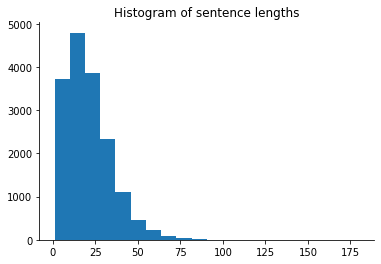

335766 words
27485 unique words


In [20]:
category = ['editorial','fiction','government','news','religion']

# get all sentences in this category
sentences = brown.sents(categories=category);
print(f'{len(sentences)} sentences')

# histogram of sentence lengths
lengths = [len(sent) for sent in sentences];
plt.hist(lengths,bins=20); sns.despine();
plt.title('Histogram of sentence lengths'); plt.show()

# build word corpus
corpus_words = [];
for sent in sentences:
    for word in sent:
        if "''" not in word and "``" not in word:
              corpus_words.append(word)
print(f'{len(corpus_words)} words')

# make distinct word set
unique_words = list(set(corpus_words)); print(f'{len(unique_words)} unique words')
word_idx_dict = {word: i for i, word in enumerate(unique_words)}
next_word = np.zeros([len(unique_words), len(unique_words)])
for i, word in enumerate(corpus_words[-1]):
    first_word_idx = word_idx_dict[word];
    next_word_idx = word_idx_dict[corpus_words[i+1]]
    next_word[first_word_idx, next_word_idx]+=1;